In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split

from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

import math
import scipy.stats as ss

SEED = 42

def plot_scatter(df, x, y):
    sns.scatterplot(df, x=df[x], y=df[y])

rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=7,
    n_jobs=-1,
    random_state=42)

In [29]:
data = pd.read_csv("../dset/kaggle_river_playground/sample_submission.csv")
print(data.shape)
data.head(5)

(3500, 37)


,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


In [30]:
X, y = data.drop('target', axis = 1), data.target

# scores = cross_val_score(rf, 
#                        X, 
#                        y,
#                        cv = 10, 
#                        scoring = 'neg_mean_squared_error',
#                        n_jobs = -1)
# 
# print(f'MSE Mean (BASELINE): {scores.mean()}, Standard Deviation: {scores.std()}')

In [31]:
data.target = data['target'].clip(lower=7, upper=20);


In [32]:
svm = SGDOneClassSVM(nu=0.55)
yhat = svm.fit_predict(data.drop('id', axis=1))

print(yhat)
print('outliers: ', np.count_nonzero(yhat == -1))

mask = yhat != -1
data_svm = data.loc[mask, : ].reset_index(drop=True)
X_SVM, Y_SVM = data_svm.drop('target', axis=1), data_svm['target']

# scores = cross_val_score(rf, 
#                        X_SVM,
#                        Y_SVM,
#                        cv = 10, 
#                        scoring = 'neg_mean_squared_error',
#                        n_jobs = -1)
# 
# print(f'[{svm.__class__.__name__}] --> MSE Mean: {scores.mean()}, Standard Deviation: {scores.std()}')
data_svm.head()



[1 1 1 ... 1 1 1]
outliers:  27


,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


In [33]:
iso = IsolationForest(random_state=0)
yhat = iso.fit_predict(data_svm.drop('id', axis=1))
print('outliers: ', np.count_nonzero(yhat == -1))

mask = yhat != -1
data_iso = data_svm.loc[mask,: ].reset_index(drop=True)

X_ISO, Y_ISO = data_iso.drop('target', axis=1), data_iso['target']

outliers:  90


In [34]:
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
yhat = lof.fit_predict(data_iso.drop(['id', 'target'], axis=1))

print('outliers: ', np.count_nonzero(yhat==-1))

mask = yhat != -1
data_final = data_iso.loc[mask,:].reset_index(drop=True)
X_LOF, Y_LOF = data_final.drop('target', axis = 1), data_final['target']

outliers:  339


In [35]:
X_final, y_final = data_final.drop('target', axis=1), data_final['target']
print(X_final.head(10), y_final.head(10), data_final.head(10))

   id    O2_1   O2_2    O2_3   O2_4   O2_5    O2_6   O2_7  NH4_1  NH4_2  ...  \
0   0   7.500   9.00   9.545  9.265  8.110   8.430  7.150  0.180  0.200  ...   
1   1  13.533  40.90   8.770  9.265  6.015  10.070  7.150  1.107  1.027  ...   
2   2   3.710   5.42   8.770  9.265  4.550  10.070  7.150  0.020  0.020  ...   
3   3   8.700   8.10   9.500  9.200  5.200   8.670  6.670  0.280  0.270  ...   
4   4   8.050   8.65   7.960  9.265  3.290  10.070  7.150  0.360  0.435  ...   
5   5   9.000   9.00  11.475  9.115  8.110   8.980  6.375  0.240  0.245  ...   
6   6   7.500   8.50   9.000  9.115  6.025   9.805  5.030  0.300  0.300  ...   
7   7   7.350   8.10   9.545  9.115  6.025   8.980  7.150  0.300  0.300  ...   
8   8   6.400   8.40   8.370  7.890  5.075  10.070  5.030  0.240  0.200  ...   
9   9   7.400   8.40   9.545  7.600  4.000   9.805  5.030  0.140  0.200  ...   

    NO3_5  NO3_6  NO3_7  BOD5_1  BOD5_2  BOD5_3  BOD5_4  BOD5_5  BOD5_6  \
0   4.950  1.730  1.800   4.800    3.15  10.

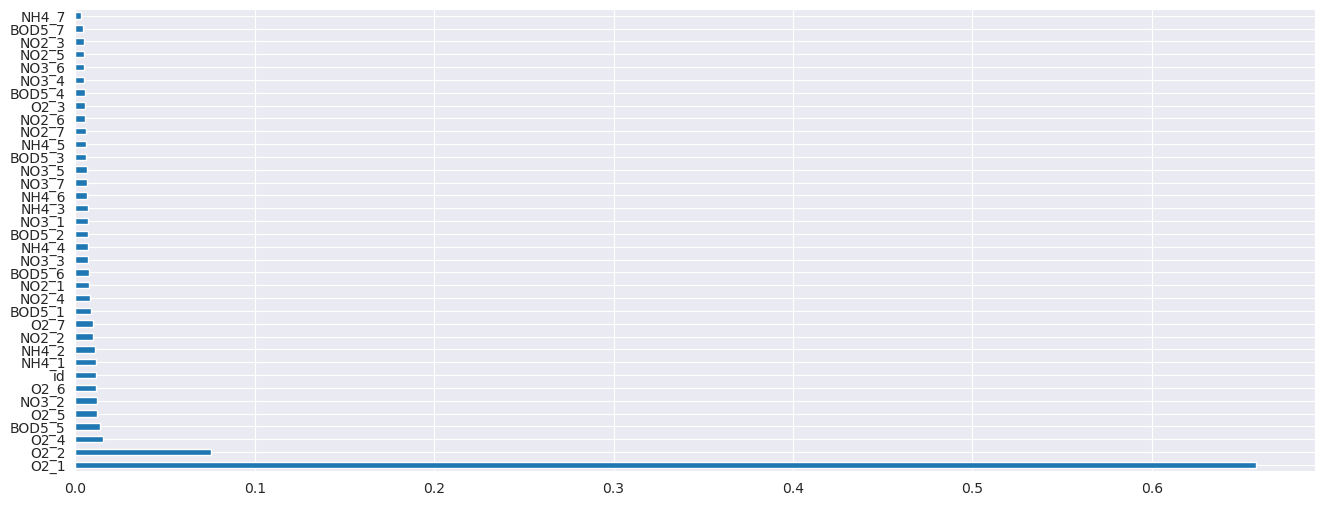

In [36]:
rf.fit(X_final, y_final)

important_features = pd.DataFrame({'importance': rf.feature_importances_}, index=X_final.columns).sort_values(by='importance', ascending=False)
important_features.plot(figsize=(16, 6), kind="barh").get_legend().remove()

In [37]:
selected = important_features.nlargest(4, 'importance').index

scores = cross_val_score(rf, X_final[selected], y_final, cv = 10, scoring='neg_mean_squared_error', n_jobs=-1)
print('mean: ', scores.mean(), 'standard deviation: ', scores.std())

mean:  -0.8643841467081448 standard deviation:  0.1523284801312228


In [38]:
data_final.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


In [39]:
bad_labels = [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]
data_final = data_final[~data_final['id'].isin(bad_labels)]

for column in X.columns:
    if column not in selected:
        data_final[column] = 0


In [40]:
drop_index = np.random.choice(data_final[data_final['target']==7].index.to_numpy(), 150, replace=False)
data_final.drop(drop_index, inplace = True)

In [41]:
submission = data_final.reset_index(drop = True).copy()
submission.head()

submission.to_csv('submission.csv', index = False)